In [1]:
import scipy.sparse as sps
import numpy as np
import pandas as pd
import scipy as sc

# Import data and divide it in playlists and songs

In [2]:
data = np.genfromtxt('train.csv' , delimiter=',',dtype=int)[1:]

In [3]:
data.shape

(1211791, 2)

In [4]:
playlist = data[:,0]
song = data[:,1]

In [106]:
playlist

array([    0,     0,     0, ..., 50445, 50445, 50445])

# Transform the data in a sparse matrix

In [42]:
unique_playlist = list(set(playlist))
unique_songs = list(set(song))

num_playlists = len(unique_playlist)
num_songs = len(unique_songs)

In [43]:
mat = sps.lil_matrix((num_playlists,num_songs))

In [44]:
mat[playlist,song] = 1

In [75]:
mat

<50446x20635 sparse matrix of type '<class 'numpy.float64'>'
	with 1211791 stored elements in LInked List format>

In [45]:
csr_mat = sc.sparse.csr_matrix(mat)

In [25]:
csr_mat.indices

array([ 1220,  8360, 12844, ..., 19431, 19991, 20605], dtype=int32)

In [26]:
csr_mat.indptr

array([      0,       5,      45, ..., 1211735, 1211749, 1211791], dtype=int32)

In [41]:
csr_mat.data

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

# Count the unique elements for statistics


In [28]:
num_playlists

50446

In [29]:
num_songs

20635

In [30]:
number_interactions = len(playlist)

In [31]:
number_interactions

1211791

# Statistics

In [32]:
print ("Number of songs\t {}, Number of playlist\t {}".format(num_songs, num_playlists))
print ("Average interactions per playlist {:.2f}".format(number_interactions/num_playlists))
print ("Average interactions per song {:.2f}\n".format(number_interactions/num_songs))

print ("Sparsity {:.2f} %".format((1-float(number_interactions)/(num_playlists*num_songs))*100))


Number of songs	 20635, Number of playlist	 50446
Average interactions per playlist 24.02
Average interactions per song 58.73

Sparsity 99.88 %


# First super basic selection of popular songs

In [46]:
song_pop = (csr_mat>0).sum(axis=0)
song_pop

matrix([[ 26,  51,  56, ..., 133,   7,   2]], dtype=int32)

In [47]:
song_pop = np.array(song_pop).squeeze()

In [35]:
song_pop

array([ 26,  51,  56, ..., 133,   7,   2], dtype=int32)

In [52]:
x = np.argsort(song_pop)
x = np.flip(x,axis=0)
y = x[:10]

y
2674 5606 8956 10496 10848 13980 15578 17239 18266

array([ 8956, 10848,  5606, 15578, 10496, 17239,  2674, 13980, 18266,  2272], dtype=int64)

# Plotting the results and analizing stats

In [33]:
import matplotlib.pyplot as pyplot

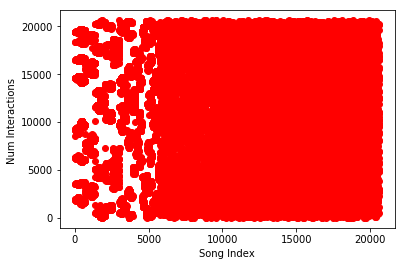

In [34]:
pyplot.plot(song_pop, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Song Index')
pyplot.show()

In [40]:
tenPercent = int(num_songs/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(song_pop.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(song_pop[-tenPercent].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(song_pop[:tenPercent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(song_pop[int(num_songs*0.45):int(num_songs*0.55)].mean()))

Average per-item interactions over the whole dataset 58.73
Average per-item interactions for the top 10% popular items 157.00
Average per-item interactions for the least 10% popular items 1.00
Average per-item interactions for the median 10% popular items 15.44


In [41]:
print("Number of items with zero interactions {}".
      format(np.sum(song_pop==0)))

Number of items with zero interactions 0


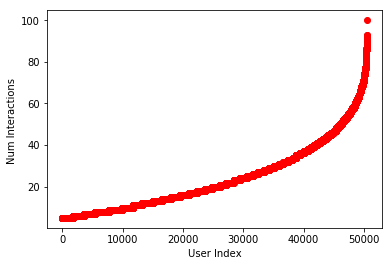

In [42]:
userActivity = (csr_mat>0).sum(axis=1)
userActivity = np.array(userActivity).squeeze()
userActivity = np.sort(userActivity)


pyplot.plot(userActivity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('User Index')
pyplot.show()

# Dividing test and training set for ML.

In [12]:
train_test_split = 0.80
numInteractions = csr_mat.nnz
train_mask = np.random.choice([True,False], numInteractions, p=[train_test_split, 1-train_test_split])


playlist = np.array(playlist)
song = np.array(song)

train = sps.coo_matrix((csr_mat.data[train_mask], (playlist[train_mask], song[train_mask])))
train = train.tocsr()
train

<50446x20635 sparse matrix of type '<class 'numpy.float64'>'
	with 968990 stored elements in Compressed Sparse Row format>

In [13]:
test_mask = np.logical_not(train_mask)

test = sps.coo_matrix((csr_mat.data[test_mask], (playlist[test_mask], song[test_mask])))
test = test.tocsr()
test

<50446x20634 sparse matrix of type '<class 'numpy.float64'>'
	with 242801 stored elements in Compressed Sparse Row format>

# Evaluation

In [14]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

In [15]:
def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

In [16]:
def MAP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score

In [17]:
# We pass as paramether the recommender class

def evaluate_algorithm(test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0


    for playlist in unique_playlist:

        relevant_items = test[playlist].indices
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(playlist, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_MAP += MAP(recommended_items, relevant_items)


    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    print("Recommender performance is: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP)) 


In [18]:
class RandomRecommender(object):

    def fit(self, train):
           
        self.numItems = train.shape[0]
    
    
    def recommend(self, song_id, at=5):
    
        recommended_items = np.random.choice(self.numItems, at)

        return recommended_items

In [19]:
randomRecommender = RandomRecommender()
randomRecommender.fit(train)

recommended_items = randomRecommender.recommend(song, at=10)
recommended_items

array([44238, 34209,   998, 47672, 41282, 31569, 39036, 44255, 11810, 26099])

In [20]:
evaluate_algorithm(test, randomRecommender)

Recommender performance is: Precision = 0.0001, Recall = 0.0001, MAP = 0.0001


# TOP POP

In [21]:
class TopPopRecommender(object):

    def fit(self, train):

        itemPopularity = (train>0).sum(axis=0)
        itemPopularity = np.array(itemPopularity).squeeze()

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popularItems = np.argsort(itemPopularity)
        self.popularItems = np.flip(self.popularItems, axis = 0)
    
     
    def recommend(self, user_id, at=5):
    
        recommended_items = self.popularItems[0:at]

        return recommended_items


In [22]:
topPopRecommender = TopPopRecommender()
topPopRecommender.fit(train)

In [23]:
for user_id in unique_playlist[0:10]:
    print(topPopRecommender.recommend(user_id, at=10))

[ 8956 10848  5606 15578  2674 10496 17239 13980  2272 18266]
[ 8956 10848  5606 15578  2674 10496 17239 13980  2272 18266]
[ 8956 10848  5606 15578  2674 10496 17239 13980  2272 18266]
[ 8956 10848  5606 15578  2674 10496 17239 13980  2272 18266]
[ 8956 10848  5606 15578  2674 10496 17239 13980  2272 18266]
[ 8956 10848  5606 15578  2674 10496 17239 13980  2272 18266]
[ 8956 10848  5606 15578  2674 10496 17239 13980  2272 18266]
[ 8956 10848  5606 15578  2674 10496 17239 13980  2272 18266]
[ 8956 10848  5606 15578  2674 10496 17239 13980  2272 18266]
[ 8956 10848  5606 15578  2674 10496 17239 13980  2272 18266]


In [24]:
evaluate_algorithm(test, topPopRecommender, at=10)

Recommender performance is: Precision = 0.0064, Recall = 0.0112, MAP = 0.0039


In [25]:
class TopPopRecommender(object):

    def fit(self, train):
        
        self.train = train

        itemPopularity = (train>0).sum(axis=0)
        itemPopularity = np.array(itemPopularity).squeeze()

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popularItems = np.argsort(itemPopularity)
        self.popularItems = np.flip(self.popularItems, axis = 0)
    
    
    def recommend(self, user_id, at=10, remove_seen=True):

        if remove_seen:
            unseen_items_mask = np.in1d(self.popularItems, self.train[user_id].indices,
                                        assume_unique=True, invert = True)

            unseen_items = self.popularItems[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popularItems[0:at]
            
        recommended_items.sort()
        recommended_items = " ".join(str(i) for i in recommended_items)
        return recommended_items

In [26]:
topPopRecommender_removeSeen = TopPopRecommender()
topPopRecommender_removeSeen.fit(train)

for user_id in unique_playlist[0:10]:
    print(topPopRecommender_removeSeen.recommend(user_id, at=10))

2272 2674 5606 8956 10496 10848 13980 15578 17239 18266
2272 2674 5606 8956 10496 10848 13980 15578 17239 18266
2272 2674 5606 8956 10496 10848 13980 15578 17239 18266
2272 2674 5606 8956 10496 10848 13980 15578 17239 18266
2272 2674 5606 8956 10496 10848 13980 15578 17239 18266
2272 2674 5606 8956 10496 10848 13980 15578 17239 18266
2272 2674 5606 8956 10496 10848 13980 15578 17239 18266
2272 2674 5606 8956 10496 10848 13980 15578 17239 18266
2272 2674 5606 8956 10496 10848 13980 15578 17239 18266
2272 2674 5606 8956 10496 10848 13980 15578 17239 18266


In [27]:
evaluate_algorithm(test, topPopRecommender_removeSeen)

C:\Users\Antonio\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Recommender performance is: Precision = 0.0000, Recall = 0.0000, MAP = 0.0000
